# Bounds in rounds

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import torchist
import swyft
import pytorch_lightning as pl

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.z_sampler = swyft.RectBoundSampler(
            [stats.norm(0, 1), stats.uniform(0, 1)],
        bounds = bounds)
        
    def build(self, graph):
        z = graph.node('z', self.z_sampler)
        x = graph.node('x', lambda z: z + np.random.randn(1)*0.001, z)
  

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 2, num_params = 2, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

In [5]:
def swyft_round(N, obs, bounds):
    # Generate training / validation / test data
    sim = Simulator(bounds = bounds)
    samples = sim.sample(N)
    dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.02, 0.1], num_workers = 3, batch_size = 8)
    
    # Initialize inference network
    network = Network()

    # Train inference network
    model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k = 1)
    logger = pl.loggers.TensorBoardLogger("./lightning_logs", name = "Test1")
    trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 2, precision = 64, logger = logger, callbacks = [model_checkpoint])
    trainer.fit(network, dm)
    
    # Evaluate
    prior_samples = sim.sample(N = 10000, targets = ['z'])
    predictions = trainer.infer(network, obs, prior_samples)
    bounds = swyft.collect_rect_bounds(predictions, 'z', (2,), threshold = 3e-5)

    return predictions, bounds

In [10]:
obs = swyft.Sample(x = np.array([0.3, 0.5]))
predictions1, bounds = swyft_round(3000, obs, None)
predictions2, bounds = swyft_round(3000, obs, bounds)
predictions3, _ = swyft_round(10000, obs, bounds)

100%|██████████| 3000/3000 [00:00<00:00, 4107.55it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 34.9 K
-----------------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.280     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
100%|██████████| 10000/10000 [00:02<00:00, 4131.37it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 327it [00:00, ?it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3761.65it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 34.9 K
-----------------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.280     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
100%|██████████| 10000/10000 [00:02<00:00, 3786.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 327it [00:00, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4246.99it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 34.9 K
-----------------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.280     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
100%|██████████| 10000/10000 [00:02<00:00, 4014.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 1088it [00:00, ?it/s]

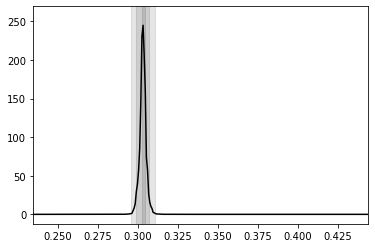

In [39]:
swyft.plot_1d(predictions3, "z[0]", ax = plt.gca(), smooth = 0, bins = 300)

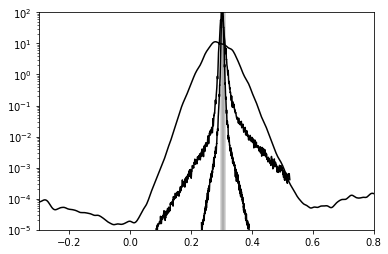

In [37]:
swyft.plot_1d(predictions1, "z[0]", ax = plt.gca(), smooth = 3, bins = 3000, contours = False)
swyft.plot_1d(predictions2, "z[0]", ax = plt.gca(), smooth = 3, bins = 3000, contours = False)
swyft.plot_1d(predictions3, "z[0]", ax = plt.gca(), smooth = 3, bins = 3000, contours = True)
plt.xlim([-0.3, 0.8])
plt.ylim([1e-5, 1e2])
plt.yscale('log')